# Clase 10:	Inclusión de un activo libre de riesgo en el portafolio

[Juan Diego Sánchez Torres](https://www.researchgate.net/profile/Juan_Diego_Sanchez_Torres), 

*Profesor*, [MAF ITESO](http://maf.iteso.mx/web/general/detalle?group_id=5858156)

+ Departamento de Matemáticas y Física
+ dsanchez@iteso.mx
+ Tel. 3669-34-34 Ext. 3069
+ Oficina: Cubículo 4, Edificio J, 2do piso

# 1. Motivación

En primer lugar, para poder bajar precios y información sobre opciones de Yahoo, es necesario cargar algunos paquetes de Python. En este caso, el paquete principal será Pandas. También, se usarán el Scipy y el Numpy para las matemáticas necesarias y, el Matplotlib y el Seaborn para hacer gráficos de las series de datos.

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
from datetime import datetime
import scipy.stats as stats
import scipy as sp
import scipy.optimize as scopt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.covariance as skcov
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

# 2. Uso de Pandas para descargar datos de precios de cierre

Bajar datos en forma de función

In [2]:
def get_historical_closes(ticker, start_date, end_date):
    p = web.DataReader(ticker, "yahoo", start_date, end_date).sort_index('major_axis')
    d = p.to_frame()['Adj Close'].reset_index()
    d.rename(columns={'minor': 'Ticker', 'Adj Close': 'Close'}, inplace=True)
    pivoted = d.pivot(index='Date', columns='Ticker')
    pivoted.columns = pivoted.columns.droplevel(0)
    return pivoted

Una vez cargados los paquetes, es necesario definir los tickers de las acciones que se usarán, la fuente de descarga (Yahoo en este caso, pero también se puede desde Google) y las fechas de interés. Con esto, la función *DataReader* del paquete *pandas_datareader* bajará los precios solicitados.

**Nota**: Usualmente, las distribuciones de Python no cuentan, por defecto, con el paquete *pandas_datareader*. Por lo que será necesario instalarlo aparte. El siguiente comando instala el paquete en Anaconda:
*conda install -c conda-forge pandas-datareader *

In [3]:
assets = ['AAPL','MSFT','AA','AMZN','KO','QAI']
closes=get_historical_closes(assets, '2016-01-01', '2017-09-22')
closes

Ticker,AA,AAPL,AMZN,KO,MSFT,QAI
Date,,,,,,
2016-01-04,23.008,101.791,636.99,40.056,52.434,28.369
2016-01-05,21.965,99.240,633.79,40.198,52.673,28.339
2016-01-06,20.401,97.298,632.65,39.980,51.716,28.349
2016-01-07,19.596,93.191,607.94,39.319,49.917,28.209
2016-01-08,19.122,93.684,607.05,39.215,50.070,28.169
...,...,...,...,...,...,...
2017-09-18,44.910,158.670,974.19,46.110,75.160,29.840
2017-09-19,46.200,158.730,969.86,45.980,75.440,29.900
2017-09-20,47.500,156.070,973.21,45.780,74.940,29.870


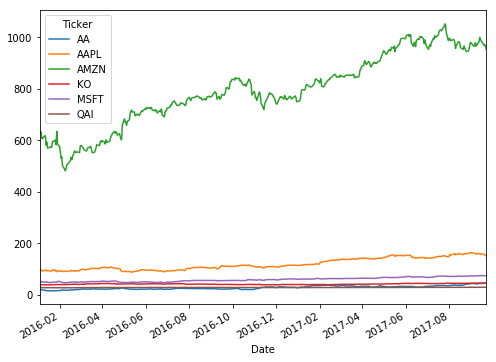

In [4]:
closes.plot(figsize=(8,6));

**Nota**: Para descargar datos de la bolsa mexicana de valores (BMV), el ticker debe tener la extensión MX. 
Por ejemplo: *MEXCHEM.MX*, *LABB.MX*, *GFINBURO.MX* y *GFNORTEO.MX*.

# 3. Formulación del riesgo de un portafolio

In [5]:
def calc_daily_returns(closes):
    return np.log(closes/closes.shift(1))[1:]

In [6]:
daily_returns=calc_daily_returns(closes)
daily_returns

Ticker,AA,AAPL,AMZN,KO,MSFT,QAI
Date,,,,,,
2016-01-05,-0.046,-2.538e-02,-0.005,0.004,4.552e-03,-1.058e-03
2016-01-06,-0.074,-1.976e-02,-0.002,-0.005,-1.833e-02,3.528e-04
2016-01-07,-0.040,-4.312e-02,-0.040,-0.017,-3.540e-02,-4.951e-03
2016-01-08,-0.024,5.274e-03,-0.001,-0.003,3.062e-03,-1.419e-03
2016-01-11,-0.009,1.606e-02,0.017,0.002,-5.735e-04,-2.488e-03
...,...,...,...,...,...,...
2017-09-18,0.006,-7.597e-03,-0.013,-0.002,-1.994e-03,0.000e+00
2017-09-19,0.028,3.781e-04,-0.004,-0.003,3.718e-03,2.009e-03
2017-09-20,0.028,-1.690e-02,0.003,-0.004,-6.650e-03,-1.004e-03


In [7]:
daily_returns_b=calc_daily_returns(closes)
yb=0.000001
daily_returns_b['BOND']=yb*np.ones(daily_returns.index.size)
daily_returns_b

Ticker,AA,AAPL,AMZN,...,MSFT,QAI,BOND
Date,,,,,,,
2016-01-05,-0.046,-2.538e-02,-0.005,...,4.552e-03,-1.058e-03,1.000e-06
2016-01-06,-0.074,-1.976e-02,-0.002,...,-1.833e-02,3.528e-04,1.000e-06
2016-01-07,-0.040,-4.312e-02,-0.040,...,-3.540e-02,-4.951e-03,1.000e-06
2016-01-08,-0.024,5.274e-03,-0.001,...,3.062e-03,-1.419e-03,1.000e-06
2016-01-11,-0.009,1.606e-02,0.017,...,-5.735e-04,-2.488e-03,1.000e-06
...,...,...,...,...,...,...,...
2017-09-18,0.006,-7.597e-03,-0.013,...,-1.994e-03,0.000e+00,1.000e-06
2017-09-19,0.028,3.781e-04,-0.004,...,3.718e-03,2.009e-03,1.000e-06
2017-09-20,0.028,-1.690e-02,0.003,...,-6.650e-03,-1.004e-03,1.000e-06


In [8]:
mean_daily_returns = pd.DataFrame(daily_returns.mean(),columns=['Mean'],index=daily_returns.columns)
mean_daily_returns

,Mean
Ticker,
AA,1.565e-03
AAPL,9.222e-04
AMZN,9.333e-04
KO,2.931e-04
MSFT,8.066e-04
QAI,1.172e-04


In [9]:
mean_daily_returns_b = pd.DataFrame(daily_returns_b.mean(),columns=['Mean'],index=daily_returns_b.columns)
mean_daily_returns_b

,Mean
Ticker,
AA,1.565e-03
AAPL,9.222e-04
AMZN,9.333e-04
KO,2.931e-04
MSFT,8.066e-04
QAI,1.172e-04
BOND,1.000e-06


In [10]:
cov_matrix = daily_returns.cov()
cov_matrix

Ticker,AA,AAPL,AMZN,KO,MSFT,QAI
Ticker,,,,,,
AA,7.844e-04,7.749e-05,7.511e-05,2.012e-05,8.437e-05,1.813e-05
AAPL,7.749e-05,1.776e-04,8.267e-05,1.868e-05,7.747e-05,1.305e-05
AMZN,7.511e-05,8.267e-05,2.416e-04,3.103e-05,9.441e-05,1.430e-05
KO,2.012e-05,1.868e-05,3.103e-05,5.785e-05,3.292e-05,6.176e-06
MSFT,8.437e-05,7.747e-05,9.441e-05,3.292e-05,1.471e-04,1.337e-05
QAI,1.813e-05,1.305e-05,1.430e-05,6.176e-06,1.337e-05,4.751e-06


In [11]:
daily_returns.corr().stack().sort_values(axis=0, ascending=True, kind='quicksort')

Ticker  Ticker
AA      KO        0.094
KO      AA        0.094
AA      AMZN      0.173
AMZN    AA        0.173
AAPL    KO        0.184
                  ...  
KO      KO        1.000
AMZN    AMZN      1.000
AAPL    AAPL      1.000
MSFT    MSFT      1.000
QAI     QAI       1.000
Length: 36, dtype: float64

In [12]:
cov_matrix_b = daily_returns_b.cov()
cov_matrix_b

Ticker,AA,AAPL,AMZN,...,MSFT,QAI,BOND
Ticker,,,,,,,
AA,7.844e-04,7.749e-05,7.511e-05,...,8.437e-05,1.813e-05,-3.393e-41
AAPL,7.749e-05,1.776e-04,8.267e-05,...,7.747e-05,1.305e-05,3.563e-41
AMZN,7.511e-05,8.267e-05,2.416e-04,...,9.441e-05,1.430e-05,2.715e-41
KO,2.012e-05,1.868e-05,3.103e-05,...,3.292e-05,6.176e-06,1.145e-41
MSFT,8.437e-05,7.747e-05,9.441e-05,...,1.471e-04,1.337e-05,-3.139e-41
QAI,1.813e-05,1.305e-05,1.430e-05,...,1.337e-05,4.751e-06,-1.644e-42
BOND,-3.393e-41,3.563e-41,2.715e-41,...,-3.139e-41,-1.644e-42,4.495e-44


In [13]:
#robust_cov_matrix= pd.DataFrame(skcov.EmpiricalCovariance().fit(daily_returns).covariance_,columns=daily_returns.columns,index=daily_returns.columns)
#robust_cov_matrix= pd.DataFrame(skcov.EllipticEnvelope().fit(daily_returns).covariance_,columns=daily_returns.columns,index=daily_returns.columns)
#robust_cov_matrix= pd.DataFrame(skcov.MinCovDet().fit(daily_returns).covariance_,columns=daily_returns.columns,index=daily_returns.columns)
robust_cov_matrix= pd.DataFrame(skcov.ShrunkCovariance().fit(daily_returns).covariance_,columns=daily_returns.columns,index=daily_returns.columns)
robust_cov_matrix

Ticker,AA,AAPL,AMZN,KO,MSFT,QAI
Ticker,,,,,,
AA,7.278e-04,6.958e-05,6.745e-05,1.807e-05,7.576e-05,1.628e-05
AAPL,6.958e-05,1.830e-04,7.424e-05,1.678e-05,6.957e-05,1.172e-05
AMZN,6.745e-05,7.424e-05,2.405e-04,2.786e-05,8.478e-05,1.284e-05
KO,1.807e-05,1.678e-05,2.786e-05,7.545e-05,2.956e-05,5.546e-06
MSFT,7.576e-05,6.957e-05,8.478e-05,2.956e-05,1.556e-04,1.201e-05
QAI,1.628e-05,1.172e-05,1.284e-05,5.546e-06,1.201e-05,2.777e-05


In [14]:
robust_cov_matrix_b= pd.DataFrame(np.insert((np.insert(skcov.ShrunkCovariance().fit(daily_returns).covariance_,len(assets),0,axis=0)),len(assets),0,axis=1)
,columns=daily_returns_b.columns,index=daily_returns_b.columns)
robust_cov_matrix_b

Ticker,AA,AAPL,AMZN,...,MSFT,QAI,BOND
Ticker,,,,,,,
AA,7.278e-04,6.958e-05,6.745e-05,...,7.576e-05,1.628e-05,0.0
AAPL,6.958e-05,1.830e-04,7.424e-05,...,6.957e-05,1.172e-05,0.0
AMZN,6.745e-05,7.424e-05,2.405e-04,...,8.478e-05,1.284e-05,0.0
KO,1.807e-05,1.678e-05,2.786e-05,...,2.956e-05,5.546e-06,0.0
MSFT,7.576e-05,6.957e-05,8.478e-05,...,1.556e-04,1.201e-05,0.0
QAI,1.628e-05,1.172e-05,1.284e-05,...,1.201e-05,2.777e-05,0.0
BOND,0.000e+00,0.000e+00,0.000e+00,...,0.000e+00,0.000e+00,0.0


# 4. Optimización de portafolios

In [15]:
num_portfolios = 200000
num_assets=len(assets)

r=0.0001

weights = np.array(np.random.random(num_assets*num_portfolios)).reshape(num_portfolios,num_assets)
weights = weights*np.matlib.repmat(1/weights.sum(axis=1),num_assets,1).T
rend=252*weights.dot(mean_daily_returns.values[:,0]).T
sd = np.zeros(num_portfolios)
for i in range(num_portfolios):
    sd[i]=np.sqrt(252*(((weights[i,:]).dot(robust_cov_matrix)).dot(weights[i,:].T)))    
sharpe=np.divide((rend-r),sd)
results_frame = pd.DataFrame(data=np.column_stack((rend,sd,sharpe,weights)),columns=(['Rendimiento','SD','Sharpe']+list(daily_returns.columns)))

In [16]:
#Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['Sharpe'].idxmax()]
#Menor SD
min_vol_port = results_frame.iloc[results_frame['SD'].idxmin()]

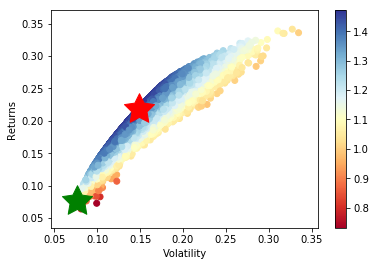

In [17]:
plt.scatter(results_frame.SD,results_frame.Rendimiento,c=results_frame.Sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=1000);
#Menor SD
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=1000);

In [18]:
pd.DataFrame(max_sharpe_port)

,68308
Rendimiento,0.219
SD,0.149
Sharpe,1.471
AA,0.146
AAPL,0.296
AMZN,0.161
KO,0.164
MSFT,0.204
QAI,0.028


In [19]:
pd.DataFrame(min_vol_port)

,106056
Rendimiento,0.076
SD,0.077
Sharpe,0.987
AA,0.033
AAPL,0.042
AMZN,0.022
KO,0.198
MSFT,0.071
QAI,0.634


In [20]:
num_assets_b=len(assets)+1
weights_b = np.array(np.random.random(num_assets_b*num_portfolios)).reshape(num_portfolios,num_assets_b)
weights_b[0:int(num_portfolios/5),-1]=weights_b[0:int(num_portfolios/5),-1]+5
weights_b = weights_b*np.matlib.repmat(1/weights_b.sum(axis=1),num_assets_b,1).T
weights_b[0,:]=np.zeros(num_assets_b) 
weights_b[0,:][-1]=1
rend_b=252*weights_b.dot(mean_daily_returns_b.values[:,0]).T
sd_b = np.zeros(num_portfolios)
for i in range(num_portfolios):
    sd_b[i]=np.sqrt(252*(((weights_b[i,:]).dot(robust_cov_matrix_b)).dot(weights_b[i,:].T)))  
sharpe_b = np.zeros(num_portfolios)  
sharpe_b[1:]=np.divide((rend_b[1:]-r),sd_b[1:])
results_frame_b = pd.DataFrame(data=np.column_stack((rend_b,sd_b,sharpe_b,weights_b)),columns=(['Rendimiento','SD','Sharpe']+list(daily_returns_b.columns)))

In [21]:
#Sharpe Ratio
max_sharpe_port_b = results_frame_b.iloc[results_frame_b['Sharpe'].idxmax()]
#Menor SD
min_vol_port_b = results_frame_b.iloc[results_frame_b['SD'].idxmin()]

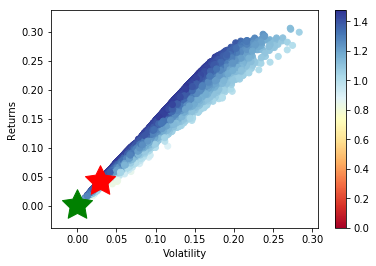

In [22]:
plt.scatter(results_frame_b.SD,results_frame_b.Rendimiento,c=results_frame_b.Sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#Sharpe Ratio
plt.scatter(max_sharpe_port_b[1],max_sharpe_port_b[0],marker=(5,1,0),color='r',s=1000);
#Menor SD
plt.scatter(min_vol_port_b[1],min_vol_port_b[0],marker=(5,1,0),color='g',s=1000);

In [23]:
pd.DataFrame(max_sharpe_port_b)

,29333
Rendimiento,0.042
SD,0.028
Sharpe,1.474
AA,0.028
AAPL,0.058
AMZN,0.033
KO,0.020
MSFT,0.038
QAI,0.009
BOND,0.814


In [24]:
pd.DataFrame(min_vol_port_b)

,0
Rendimiento,2.520e-04
SD,0.000e+00
Sharpe,0.000e+00
AA,0.000e+00
AAPL,0.000e+00
AMZN,0.000e+00
KO,0.000e+00
MSFT,0.000e+00
QAI,0.000e+00
BOND,1.000e+00


In [25]:
def sim_mont_portfolio(daily_returns,num_portfolios,risk_free):
    num_assets=len(daily_returns.T)
    #Packages
    import pandas as pd
    import sklearn.covariance as skcov
    import statsmodels.api as sm
    huber = sm.robust.scale.Huber()
    #Mean and standar deviation returns
    returns_av, scale = huber(daily_returns)
    #returns_av = daily_returns.mean()
    covariance= skcov.ShrunkCovariance().fit(daily_returns).covariance_
    #Simulated weights
    weights = np.array(np.random.random(num_assets*num_portfolios)).reshape(num_portfolios,num_assets)
    weights = weights*np.matlib.repmat(1/weights.sum(axis=1),num_assets,1).T
    ret=252*weights.dot(returns_av).T
    sd = np.zeros(num_portfolios)
    for i in range(num_portfolios):
        sd[i]=np.sqrt(252*(((weights[i,:]).dot(covariance)).dot(weights[i,:].T))) 
    sharpe=np.divide((ret-risk_free),sd)    
    return pd.DataFrame(data=np.column_stack((ret,sd,sharpe,weights)),columns=(['Returns','SD','Sharpe']+list(daily_returns.columns)))

In [36]:
results_frame = sim_mont_portfolio(daily_returns,200000,r)

In [27]:
#Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['Sharpe'].idxmax()]
#Menor SD
min_vol_port = results_frame.iloc[results_frame['SD'].idxmin()]

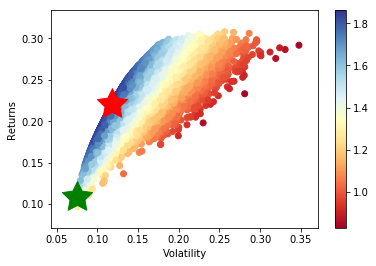

In [28]:
plt.scatter(results_frame.SD,results_frame.Returns,c=results_frame.Sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=1000);
#Menor SD
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=1000);

In [29]:
pd.DataFrame(max_sharpe_port)

,55191
Returns,0.221
SD,0.119
Sharpe,1.861
AA,0.052
AAPL,0.253
AMZN,0.153
KO,0.367
MSFT,0.087
QAI,0.089


In [30]:
pd.DataFrame(min_vol_port)

,146179
Returns,0.109
SD,0.075
Sharpe,1.438
AA,0.010
AAPL,0.090
AMZN,0.021
KO,0.250
MSFT,0.005
QAI,0.624


In [70]:
exec(open("sim_mont_portfolio_py.py").read())

In [72]:
results_frame = sim_mont_portfolio(daily_returns,20000,r)
results_frame

,Returns,SD,Sharpe,...,KO,MSFT,QAI
0,0.232,0.150,1.549,...,0.058,0.033,0.252
1,0.230,0.131,1.761,...,0.341,0.059,0.088
2,0.193,0.116,1.660,...,0.163,0.221,0.291
3,0.231,0.158,1.454,...,0.242,0.042,0.151
4,0.222,0.127,1.754,...,0.159,0.244,0.164
...,...,...,...,...,...,...,...
19995,0.215,0.129,1.669,...,0.087,0.214,0.245
19996,0.186,0.104,1.792,...,0.191,0.146,0.315
19997,0.203,0.114,1.785,...,0.156,0.207,0.246
19998,0.244,0.154,1.583,...,0.148,0.158,0.114
